# Learning in predictive coding network implemented in Nengo

Toy model of predictive coding network implemented in Nengo.
Predictive error learns the neural population of the upper layer to reproduce the same dynamics as lower layer.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import nengo

## Construct network

In [2]:
model = nengo.Network()

tau_synapse = 0.1
omega = 8
tau_synapse2 = 0.1
omega2 = 14

with model:
    freq = nengo.Ensemble(n_neurons=50, dimensions=1)
    stim_freq = nengo.Node(1)
    nengo.Connection(stim_freq, freq)
    osc = nengo.Ensemble(n_neurons=500, dimensions=3, radius=1.5)
    osc2 = nengo.Ensemble(n_neurons=500, dimensions=3, radius=1.5)
    err = nengo.Ensemble(n_neurons=500, dimensions=3, radius=1.5)

    def recurrent(x):
        return [-tau_synapse*x[2]*omega*x[1]+x[0], tau_synapse*x[2]*omega*x[0]+x[1]]
    
    def recurrent2(x):
        return [-tau_synapse*x[2]*omega2*x[1]+x[0], tau_synapse*x[2]*omega2*x[0]+x[1]]
    
    nengo.Connection(osc, osc[:2], function=recurrent, synapse=tau_synapse)
    
    def stim_func(t):
        if t < 0.1:
            return 1, 0
        else:
            return 0, 0
        
    stim = nengo.Node(stim_func)
    nengo.Connection(stim, osc[:2])
    nengo.Connection(freq, osc[2]) 
    
    nengo.Connection(osc2, osc2[:2], function=recurrent2, synapse=tau_synapse)
    nengo.Connection(osc, err, transform=-1)
    nengo.Connection(osc2, err)
    a = nengo.Connection(err, osc2, learning_rule_type=nengo.PES())
    nengo.Connection(err, a.learning_rule)

## Add probes

In [3]:
with model:
    osc_probe = nengo.Probe(osc, synapse=0.01)
    error_probe = nengo.Probe(err, synapse=0.01)
    osc2_probe = nengo.Probe(osc2, synapse=0.01)

## Run the model

In [4]:
# Create simulator
with nengo.Simulator(model) as sim:
    # Run it for several seconds
    sim.run(16)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

## Plot the results

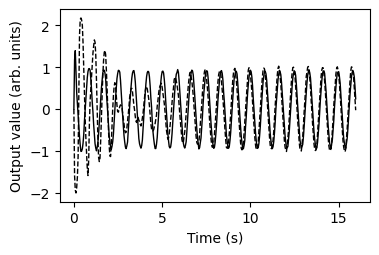

In [5]:
# Plot the decoded output of the ensemble
n = 40 # plot every n-th point
x = sim.trange()[::n]
y1 = sim.data[osc_probe][:,0][::n]
y2 = sim.data[osc2_probe][:,0][::n]

fig = plt.figure(figsize=(4,2.5))
plt.plot(x, y1, "k", label="Master oscillator", linewidth=1)
plt.plot(x, y2, "k", label="Receiver oscillator", linewidth=1, linestyle='dashed')
plt.xlabel("Time (s)", fontsize=10)
plt.ylabel("Output value (arb. units)", fontsize=10)
#plt.legend()

# save the figure if necessary
plt.savefig('Predictive_learning.svg', bbox_inches='tight')